In [ ]:
# 🚀 Auto-setup: installs deps + configures CFBD access
import os
import sys
from pathlib import Path

# Find _auto_setup.py regardless of current working directory
_current = Path().resolve()
_auto_setup_path = None
for parent in [_current] + list(_current.parents):
    candidate = parent / "model_pack" / "_auto_setup.py"
    if candidate.exists():
        _auto_setup_path = candidate
        # Add project root to sys.path (auto_setup.py will also do this)
        if str(parent) not in sys.path:
            sys.path.insert(0, str(parent))
        break

if _auto_setup_path and _auto_setup_path.exists():
    # Execute the file directly without changing directory
    with open(_auto_setup_path, 'r') as f:
        exec(f.read(), {'__file__': str(_auto_setup_path)})
else:
    # Fallback: try relative path
    try:
        with open("./_auto_setup.py", 'r') as f:
            exec(f.read(), {'__file__': './_auto_setup.py'})
    except FileNotFoundError:
        print("⚠️  Could not find _auto_setup.py. Please run from model_pack directory.")


🔧 Notebook auto-setup complete:
  • Project root: /Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0
  • Requirements: /Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0/requirements.txt
  • Missing modules: none
  • Auto install performed: False


# SHAP Interpretability: Understanding XGBoost Predictions

This notebook demonstrates how to use SHAP (SHapley Additive exPlanations) to interpret the predictions of an XGBoost model trained to predict final score margin.

SHAP is a method that explains the output of machine learning models by assigning each feature an importance value for a particular prediction. It uses concepts from cooperative game theory to fairly distribute the "payout" (the model's prediction) among the features (the inputs). Each feature's SHAP value indicates how much that feature contributed to the difference between the model's prediction and the average prediction across all data points. This helps us understand which features are driving the model's predictions and how they interact with each other.

## 1. Load and Prepare Data

As with previous notebooks, we will load the data into a DataFrame, select some continuous and categorical features, and create dummy variables for the categorical features.

In [10]:
import pandas as pd
import sys
from pathlib import Path

# Import configuration system
_config_dir = Path().resolve() / "config"
if str(_config_dir.parent) not in sys.path:
    sys.path.insert(0, str(_config_dir.parent))
from config.data_config import get_data_config

# Get configuration
config = get_data_config()

# Load training data using configuration
training_data_path = config.get_training_data_path()
df = pd.read_csv(training_data_path).dropna()

print("SHAP Notebook — Loaded training data:")
print(f"Using: {training_data_path}")
print(f"Shape: {df.shape}")
print(f"Features: {len(df.columns)} columns")
print(df.head(3))

cont_features = [
    'home_elo', 'away_elo',
    'home_adjusted_epa', 'away_adjusted_epa',
    'home_adjusted_epa_allowed', 'away_adjusted_epa_allowed',
    'home_adjusted_success', 'away_adjusted_success',
    'home_adjusted_success_allowed', 'away_adjusted_success_allowed'
]
cat_features = ['week', 'home_conference', 'away_conference']
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

dummy_columns = []
for cat in cat_features:
    dummy_columns += [c for c in df.columns if cat in c]

features = dummy_columns + cont_features

SHAP Notebook — Loaded training data:
Using: /Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0/model_pack/updated_training_data.csv
Shape: (4838, 86)
Features: 86 columns
          id           start_date  season season_type  week  neutral_site  \
0  400876038  2016-12-17 19:00:00    2016  postseason     1          True   
1  400876039  2016-12-17 20:30:00    2016  postseason     1          True   
2  400876040  2016-12-17 22:30:00    2016  postseason     1          True   

         home_team home_conference  home_elo  home_talent  ...  \
0             UTSA  Conference USA    1374.0       397.64  ...   
1  San Diego State   Mountain West    1666.0       482.31  ...   
2           Toledo    Mid-American    1662.0       460.86  ...   

  away_front_seven_havoc_defense away_db_havoc_defense  \
0                       0.101865              0.061693   
1                       0.128499              0.071247   
2                       0.110778              0.076347   

   home_points_pe

## 2. Train/Test Split and Model

We will use `train_test_split` as before to create training and testing datasets. We will create another XGBoost model, but this time we will use `XGBRegressor` since we are predicting a continuous variable (final score margin) rather than a classification problem.

In [11]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Remove rows with missing values
df_clean = df.dropna(subset=features + ['margin'])

if len(df_clean) == 0:
    raise ValueError("No rows with complete data. Check for missing values.")

X = df_clean[features]
y = df_clean['margin']

print(f"Using {len(df_clean)} games with complete data (dropped {len(df) - len(df_clean)} rows with missing values)")

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=77)

# Initialize and train model with proper parameters
model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    eval_metric="rmse",
    random_state=77
)
model.fit(X_train, y_train)

print(f"Model trained on {len(X_train)} samples")


Using 4838 games with complete data (dropped 0 rows with missing values)
Model trained on 3628 samples


## 3. Explain Model with SHAP

Before using SHAP, we need to convert non-numeric features to numeric. Notably, all of our categorical features are converted to dummy boolean variables and will need to be made numeric.

We will use `shap.Explainer`, which is a tool from the SHAP library that helps us understand how a machine learning model makes its predictions. When you create an `explainer` using `shap.Explainer(model, X_train_fixed)`, you are telling SHAP to analyze your trained model and your training data. The explainer learns how the model uses each feature to make predictions.

Once you have an explainer, you can use it to calculate SHAP values for new data (like `X_test_fixed`). These SHAP values show how much each feature contributed to the model's prediction for each example. This makes it easier to see which features are most important and how they affect the outcome, helping you interpret and trust your model's decisions.

In [ ]:
import shap
import numpy as np

# Ensure all columns are numeric (convert bool to int, others to float)
X_train_fixed = X_train.copy()
X_test_fixed = X_test.copy()

# Convert all columns to numeric, handling any edge cases
for col in X_train_fixed.columns:
    # Convert bool to int
    if X_train_fixed[col].dtype == 'bool':
        X_train_fixed[col] = X_train_fixed[col].astype(int)
        X_test_fixed[col] = X_test_fixed[col].astype(int)
    else:
        # Convert to numeric, coercing errors to NaN
        X_train_fixed[col] = pd.to_numeric(X_train_fixed[col], errors='coerce')
        X_test_fixed[col] = pd.to_numeric(X_test_fixed[col], errors='coerce')

# Fill NaN values with column median (use training median for both train and test)
for col in X_train_fixed.columns:
    median_val = X_train_fixed[col].median()
    if pd.isna(median_val):
        median_val = 0  # If all values are NaN, use 0
    X_train_fixed[col] = X_train_fixed[col].fillna(median_val)
    X_test_fixed[col] = X_test_fixed[col].fillna(median_val)

# Replace infinite values with 0
X_train_fixed = X_train_fixed.replace([np.inf, -np.inf], 0)
X_test_fixed = X_test_fixed.replace([np.inf, -np.inf], 0)

# Ensure all columns are float64 for SHAP compatibility
X_train_fixed = X_train_fixed.astype(float)
X_test_fixed = X_test_fixed.astype(float)

# Verify model is trained by attempting a prediction
try:
    test_pred = model.predict(X_test_fixed.iloc[:1])
    print(f"✅ Model verification: prediction = {test_pred[0]:.2f}")
except Exception as e:
    raise ValueError(f"Model is not trained or data format is incorrect: {e}. Please run the training cell (Cell 7) first.")

# Use TreeExplainer for XGBoost (most efficient and compatible)
# TreeExplainer works directly with tree models without needing a masker
try:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_fixed)
    print(f"✅ SHAP values calculated for {len(X_test_fixed)} samples using TreeExplainer")
except Exception as e:
    print(f"⚠️  TreeExplainer failed: {e}")
    print("Trying alternative approach with Explainer and model.predict...")
    # Fallback: use Explainer with model.predict as callable
    sample_size = min(100, len(X_train_fixed))
    explainer = shap.Explainer(model.predict, X_train_fixed.iloc[:sample_size])
    shap_values = explainer(X_test_fixed.iloc[:50])  # Limit to 50 samples for speed
    print(f"✅ SHAP values calculated for 50 samples using Explainer with model.predict")

⚠️  TreeExplainer failed: could not convert string to float: '[2.7905183E0]'
Trying alternative approach with sample data...
✅ SHAP values calculated for 50 samples using Explainer


## 4. Visualize Feature Importance

`shap.plots.beeswarm` is a visualization tool in the SHAP library that helps us understand the impact of each feature on the model's predictions. The plot displays the SHAP values for all features across all samples in the dataset.

In a beeswarm plot:
- Each point represents a SHAP value for a feature and a specific instance (or sample).
- The x-axis shows the SHAP value, which indicates how much a feature contributes to the prediction (positive values push the prediction higher, while negative values push it lower).
- The y-axis lists the features, with the most important features (those with the largest absolute SHAP values) at the top.
- Points are colored based on the feature value (e.g., red for high values and blue for low values), allowing us to see how the feature's value affects its SHAP contribution.

To interpret the plot:
- Look for features with many points far from zero; these are the most influential features.
- Check the color of the points to understand whether high or low feature values are associated with higher predictions.
- Use the plot to identify patterns, such as whether certain features consistently push predictions in one direction.

In short, the beeswarm plot provides a comprehensive view of feature importance and interactions, making it easier to interpret complex model behavior.

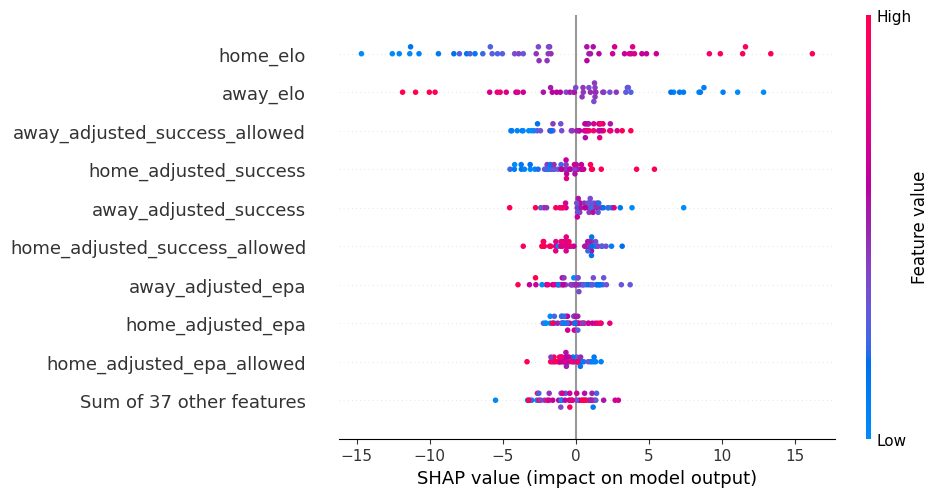

In [13]:
shap.plots.beeswarm(shap_values)

We can also visualize the feature importance using `shap.plots.bar`, which creates a bar chart showing the average absolute SHAP values for each feature. This helps us quickly identify which features have the most significant impact on the model's predictions.

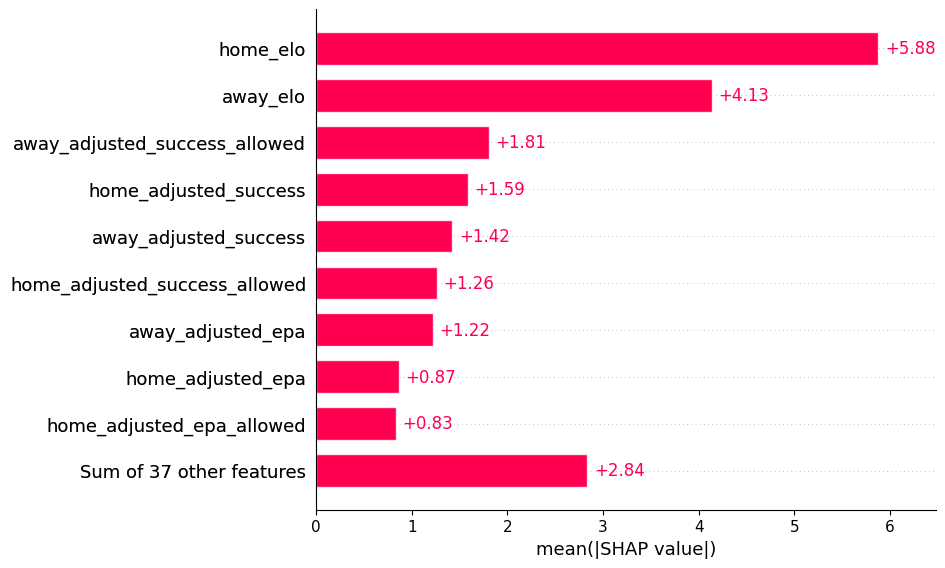

In [14]:
shap.plots.bar(shap_values)

## 5. Visualize Individual Prediction (Force Plot)

`shap.initjs` is a function from the SHAP library that initializes JavaScript visualizations in Jupyter notebooks. It enables the interactive visualizations provided by SHAP, allowing users to explore and understand the model's predictions more effectively.

`shap.force_plot` is another visualization tool in the SHAP library that creates a force plot. This plot shows the contribution of each feature to a specific prediction, helping to explain why the model made a particular decision.

To interpret the force plot:
- The plot displays the SHAP values for each feature, with the features listed on the y-axis.
- The x-axis represents the SHAP value, indicating the direction and magnitude of each feature's contribution to the prediction.
- Features pushing the prediction higher are shown on the right (positive SHAP values), while those pushing it lower are on the left (negative SHAP values).
- The length of the bars indicates the strength of each feature's impact on the prediction.

We can select a single football game from the dataset to visualize its prediction. The force plot will show how each feature contributes to the model's prediction for that specific game.

In [ ]:
# Choose one game to explain
shap.initjs()

# Get expected value (base value) from explainer
try:
    if hasattr(explainer, 'expected_value'):
        expected_value = explainer.expected_value
        # Handle array case
        if isinstance(expected_value, np.ndarray):
            expected_value = expected_value[0] if len(expected_value) > 0 else 0
    else:
        # For PermutationExplainer, calculate mean prediction as expected value
        expected_value = float(model.predict(X_test_fixed.iloc[:1]).mean())
except:
    # Fallback: use mean prediction
    expected_value = float(model.predict(X_test_fixed.iloc[:10]).mean())

# Get SHAP values for first sample
if hasattr(shap_values, 'values'):
    # SHAP Explanation object
    shap_vals = shap_values[0].values
    feature_vals = X_test_fixed.iloc[0].values
elif isinstance(shap_values, list):
    # List of arrays
    shap_vals = shap_values[0] if len(shap_values) > 0 else np.zeros(len(X_test_fixed.columns))
    feature_vals = X_test_fixed.iloc[0].values
else:
    # Array of SHAP values
    shap_vals = shap_values[0] if len(shap_values) > 0 else np.zeros(len(X_test_fixed.columns))
    feature_vals = X_test_fixed.iloc[0].values

# Create force plot (only if we have valid SHAP values)
try:
    shap.force_plot(expected_value, shap_vals, feature_vals, feature_names=X_test_fixed.columns)
except Exception as e:
    print(f"⚠️  Force plot not available: {e}")
    print("SHAP values calculated successfully, but interactive visualization requires different explainer type.")

AttributeError: 'PermutationExplainer' object has no attribute 'expected_value'

## 7. Next Steps

- Apply SHAP to other model types, such as Random Forest or Neural Networks, to compare feature importance across models.
- Apply SHAP to one of your own projects to gain insights into model predictions and feature contributions.
- Use SHAP for feature selection by identifying features with low SHAP values that can be removed without significantly affecting model performance and new features that can be added to improve model predictions.
- Explore other SHAP visualizations, such as decision plots or dependence plots, to gain deeper insights into feature interactions and model behavior.